In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import sys
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get list of Ks
k_list = [f"K{i}" for i in range(1, 13)]

admix_results_base = f'/scratch/user/uqtdenni/far_hin_1.x/work/pop_gen_2025/admixture/results/'

run = 'run1'

q_list = []
pfile_list = []
logfile_list = []

# Get paths of everything in this run
for k in k_list:
    # Build path
    run_path = glob.glob(admix_results_base + k + '/run1*')
    logfile_list.append(glob.glob(run_path[0]+'/log*'))
    pfile_list.append(glob.glob(run_path[0]+'/*.P'))
    q_list.append(glob.glob(run_path[0]+'/*.Q'))


In [3]:
# Start by parsing and plotting the crossvalidation output

cv_errors = []
loglikelihoods = []

# Iterate over the logfiles and extract the data we want (final log likelihood and cv error)
for file in logfile_list:
    with open(file[0], 'r') as f:
        for line in f:
            # CV error line: "CV error (K=10): 0.02253"
            if line.strip().startswith('CV error'):
                cv_match = re.search(r'CV error.*?: ([\d.-]+)', line)
                if cv_match:
                    cv_errors.append(float(cv_match.group(1)))
            
            # Final loglikelihood line: starts with "Loglikelihood:" (no other text before it)
            elif line.strip().startswith('Loglikelihood:') and '(QN/Block)' not in line:
                ll_match = re.search(r'Loglikelihood: ([\d.-]+)', line)
                if ll_match:
                    loglikelihoods.append(float(ll_match.group(1)))

# Bind into a dataframe
crossval = pd.DataFrame({'K' : k_list,
    'cve' : cv_errors,
    'loglik' : loglikelihoods})


<Axes: xlabel='K', ylabel='cve'>

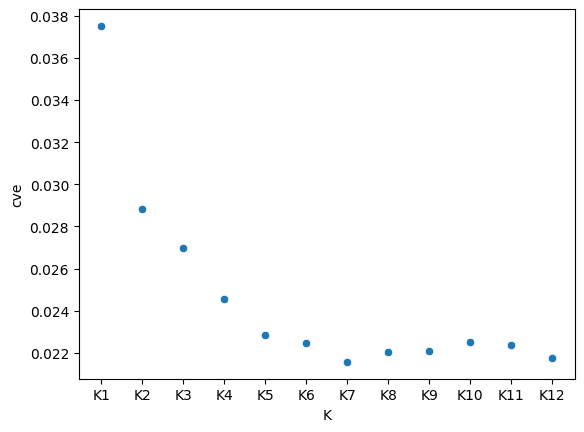

In [4]:
sns.scatterplot(data=crossval, x='K',y='cve')

<Axes: xlabel='K', ylabel='loglik'>

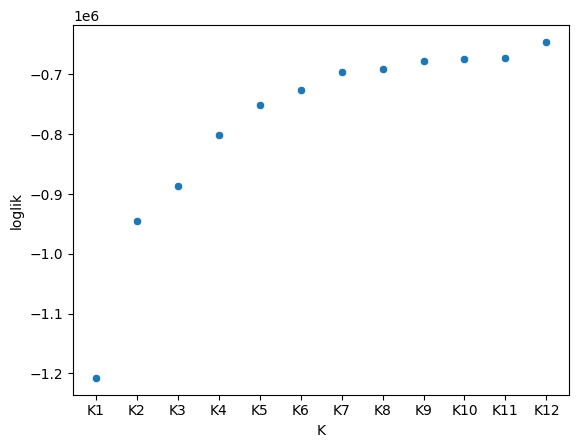

In [6]:
sns.scatterplot(data=crossval, x='K',y='loglik')

It's good form to plot a plausible range of K's - so probably K2-7 or something. Let's do that below.

In [7]:
# Because these data are unstaged, we need to faff about a bit more and load the unstaged metadata to exclude extra dud samples
df_samples_dirty = pd.read_csv('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_interim_seq_qc_pass.txt', index_col = 'derived_sample_id')
# And load the final (cleaned) metadata
df_samples = pd.read_table('/scratch/user/uqtdenni/far_hin_1.x/work/metadata_development_20250702/sample_metadata_pass_qc_fix.txt', index_col = 'derived_sample_id')

# Mask removing samples we removed before the staging step of QC (that I haven't done yet)
qc_bool = df_samples_dirty.index.isin(df_samples.index)

# Get only samples belonging to farauti ss (the ones we've used as input for admixture)

In [8]:
df_samples_analysis = df_samples.query('species_pca == "farauti_ss"')

In [21]:


#sort = ['country','admin1_iso']
#sort = propmax

#if sort == list:
#    sort by bla
#else:
# sort by proportion
K = 7
pal = sns.color_palette("Paired", K)
sns.color_palette("Paired", 7)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883)]

In [15]:
# let's plot a single barplot to start with - keep it simple and use seaborn before faffing around with interactive plotting



def plot_barplot_byadmin1(K, outpath='.'):
    # To do - specify panelling variable, and run

    # The max K we are looking at is I think 8 - won't bother plotting more than that as explanatory power decreases and error increases
    q = pd.read_csv(q_list[K-1][0], sep=' ', header=None)
    
    # Get sample data
    sample_data = df_samples_analysis[['partner_sample_id','country','admin1_iso','country_iso']].reset_index()
    
    #qdata = pd.concat([q, sample_data], axis=1)
    
    q.index = sample_data.partner_sample_id # set index as sample ids
    q.columns = [f"K{i}" for i in range(1, K+1)] #Set colnames
    q['assignment'] = q.idxmax(axis=1) # Assign pop to each based on max proportion
    
    # Set palette based on n of K
    #pal = sns.color_palette("Paired", K)
    
    # plot panel order
    iso_order = ['AU-NT', 'AU-QLD', 'PG-WPD', 'PG-MBA','PG-GPK','PG-CPM','PG-MBA','PG-MPL','PG-NPP','PG-MRL','PG-NSB','SB-WE','SB-GU','SB-MK','VU-SEE']  # your predefined order
    
    # Add country info to your Q dataframe
    q['Country'] = sample_data['admin1_iso'].values
    
    # Get unique countries and count individuals per country
    countries = iso_order#q['Country'].unique()
    country_counts = [len(q[q['Country'] == country]) for country in countries]
    
    # Calculate width ratios for subplots
    width_ratios = country_counts
    
    fig, axes = plt.subplots(1, len(countries), figsize=(25, 5), sharey=True, 
                            gridspec_kw={'width_ratios': width_ratios})
    if len(countries) == 1:
        axes = [axes]
    
    for i, country in enumerate(countries):
        country_data = q[q['Country'] == country].drop('Country', axis=1)
        
        country_data.plot.bar(stacked=True, 
                             ax=axes[i],
                             width=1,  # increase width to reduce gaps
                             color=pal, 
                             fontsize='x-small',
                             edgecolor='none', 
                             linewidth=0.01,
                             legend=False)
        
        # Style each subplot
        axes[i].spines['top'].set_visible(False)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].set_title(f'{country}', fontweight='bold')
        axes[i].set_xlabel('')
        axes[i].set_xticklabels('')
    
    axes[-1].legend(bbox_to_anchor=(1,1), fontsize='medium', labelspacing=0.5, frameon=False)
    plt.subplots_adjust(bottom=0.2, wspace=0.01)  # wspace controls width spacing
    fig.suptitle(f'K{K}', fontsize=16, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.savefig(f'{outpath}/{K}.svg')
    plt.show()
    


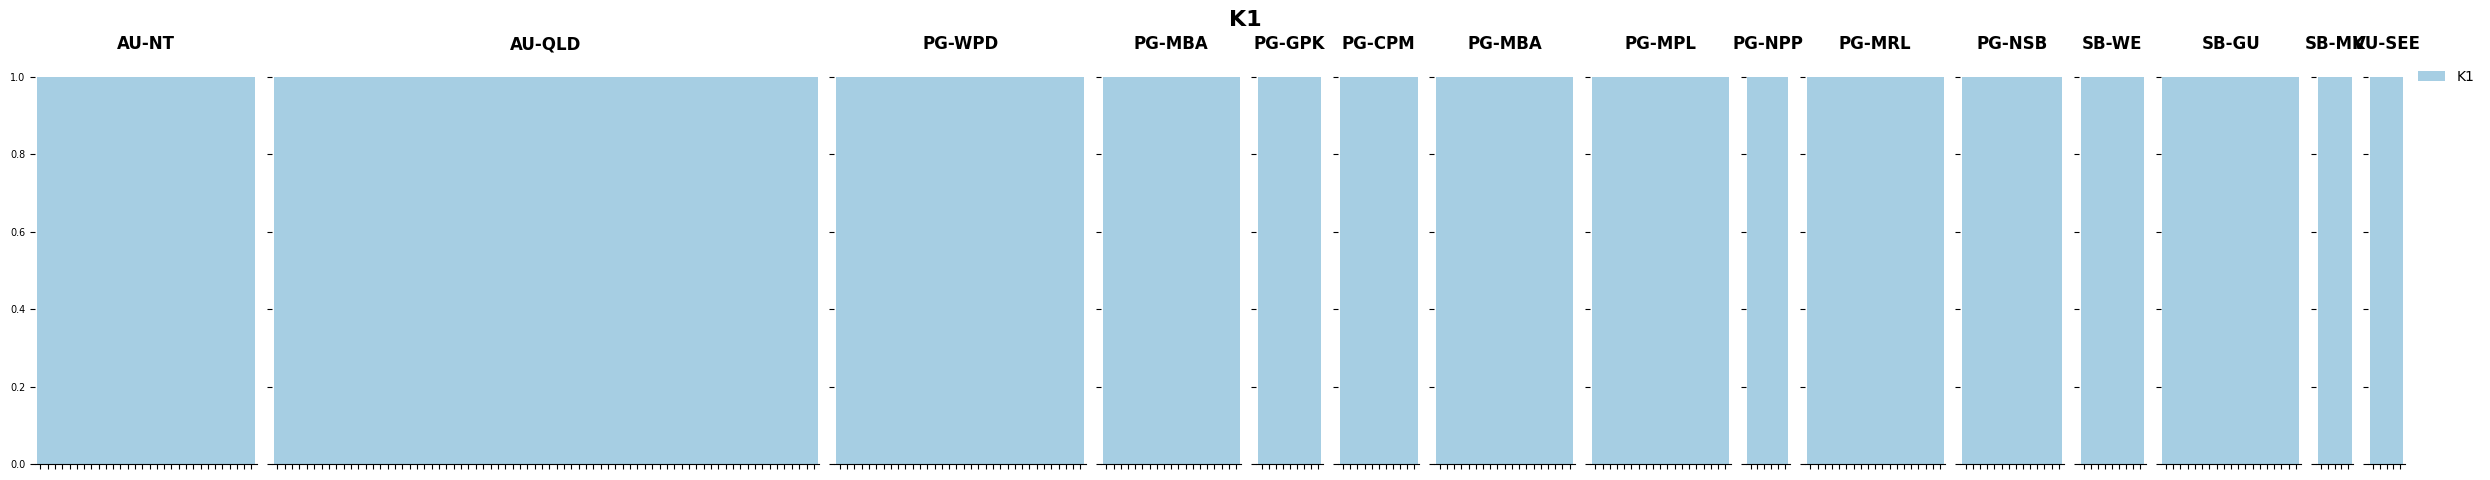

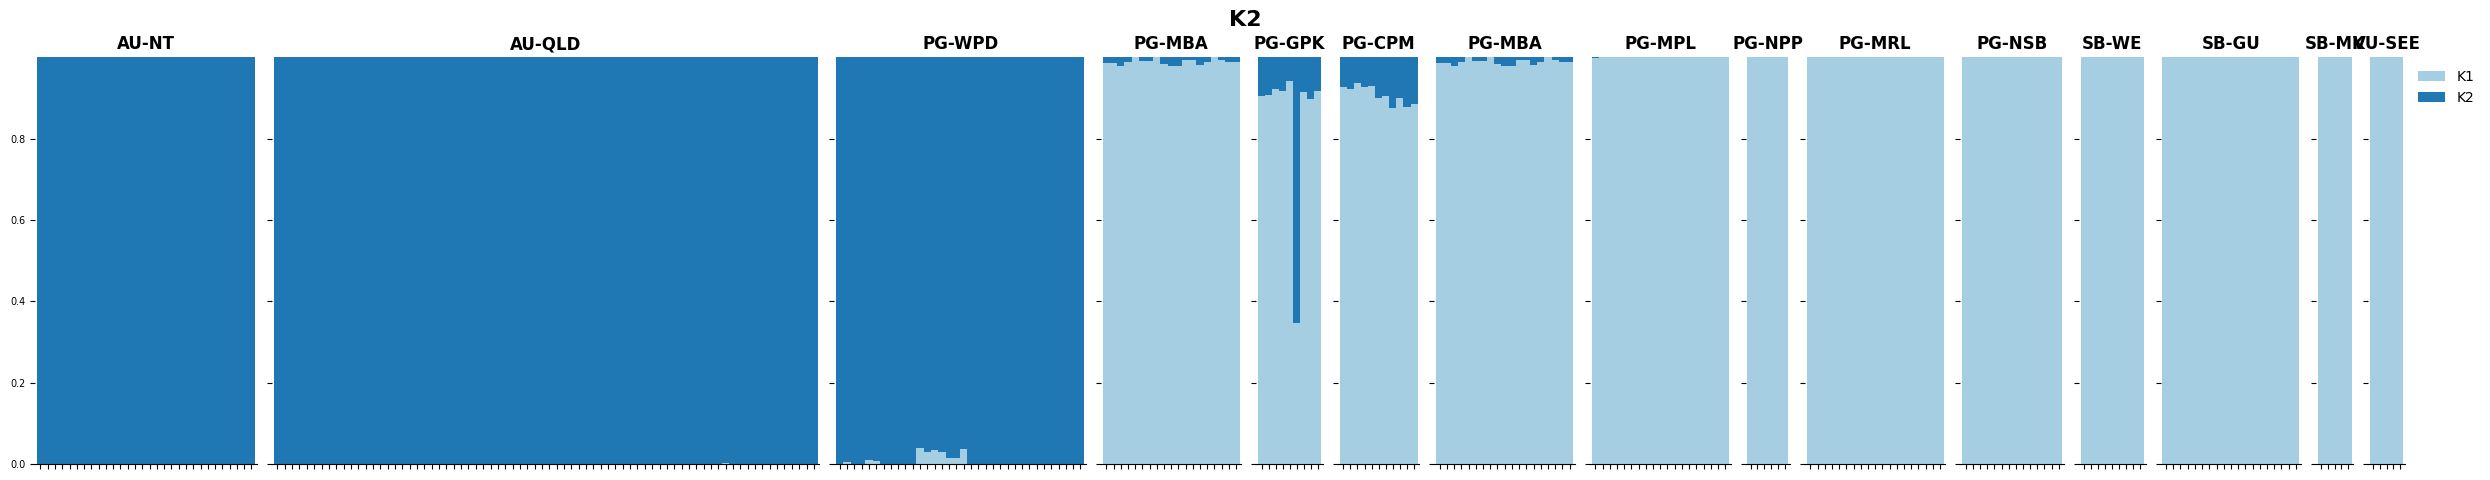

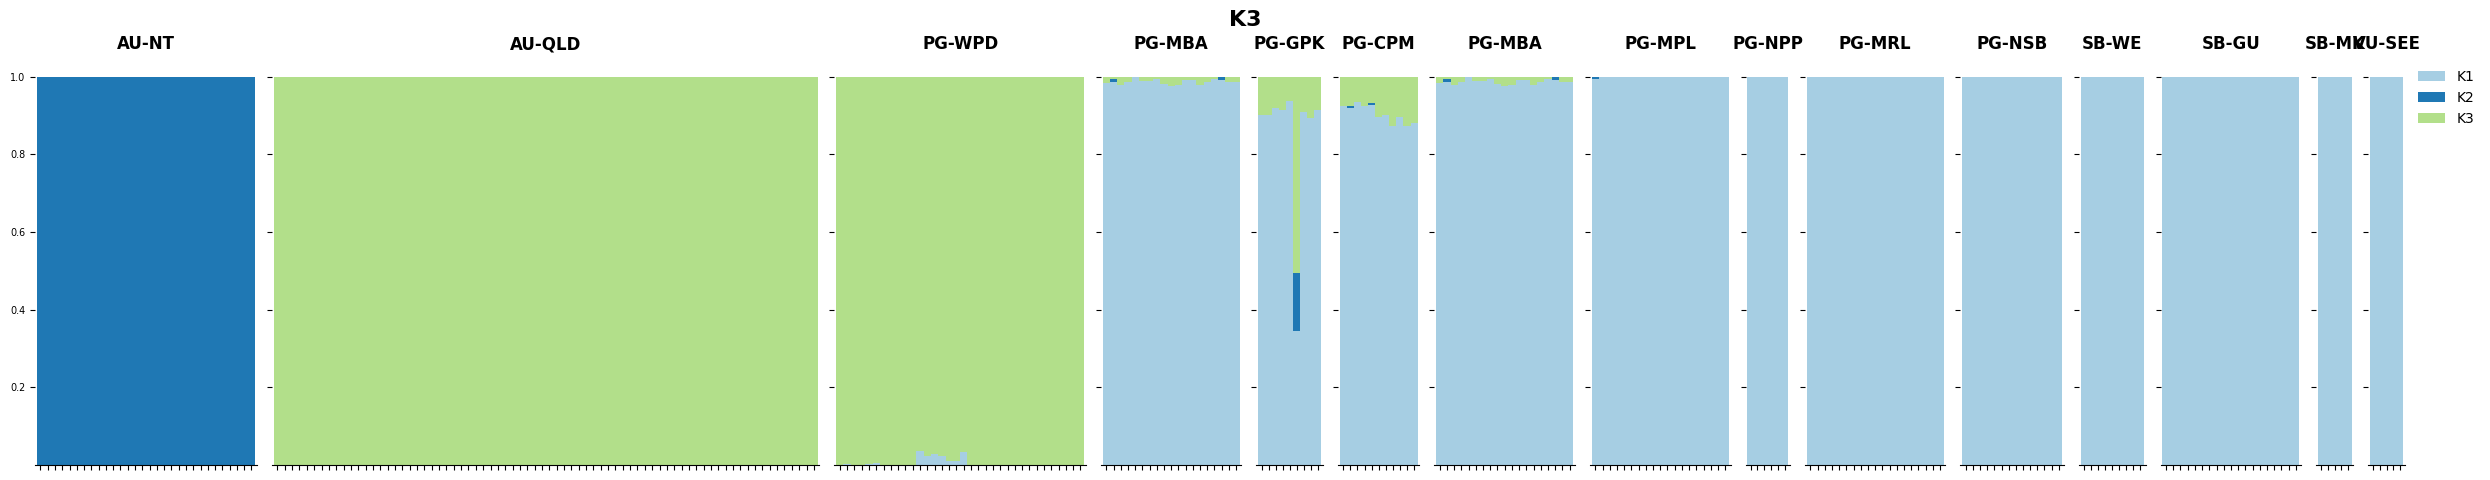

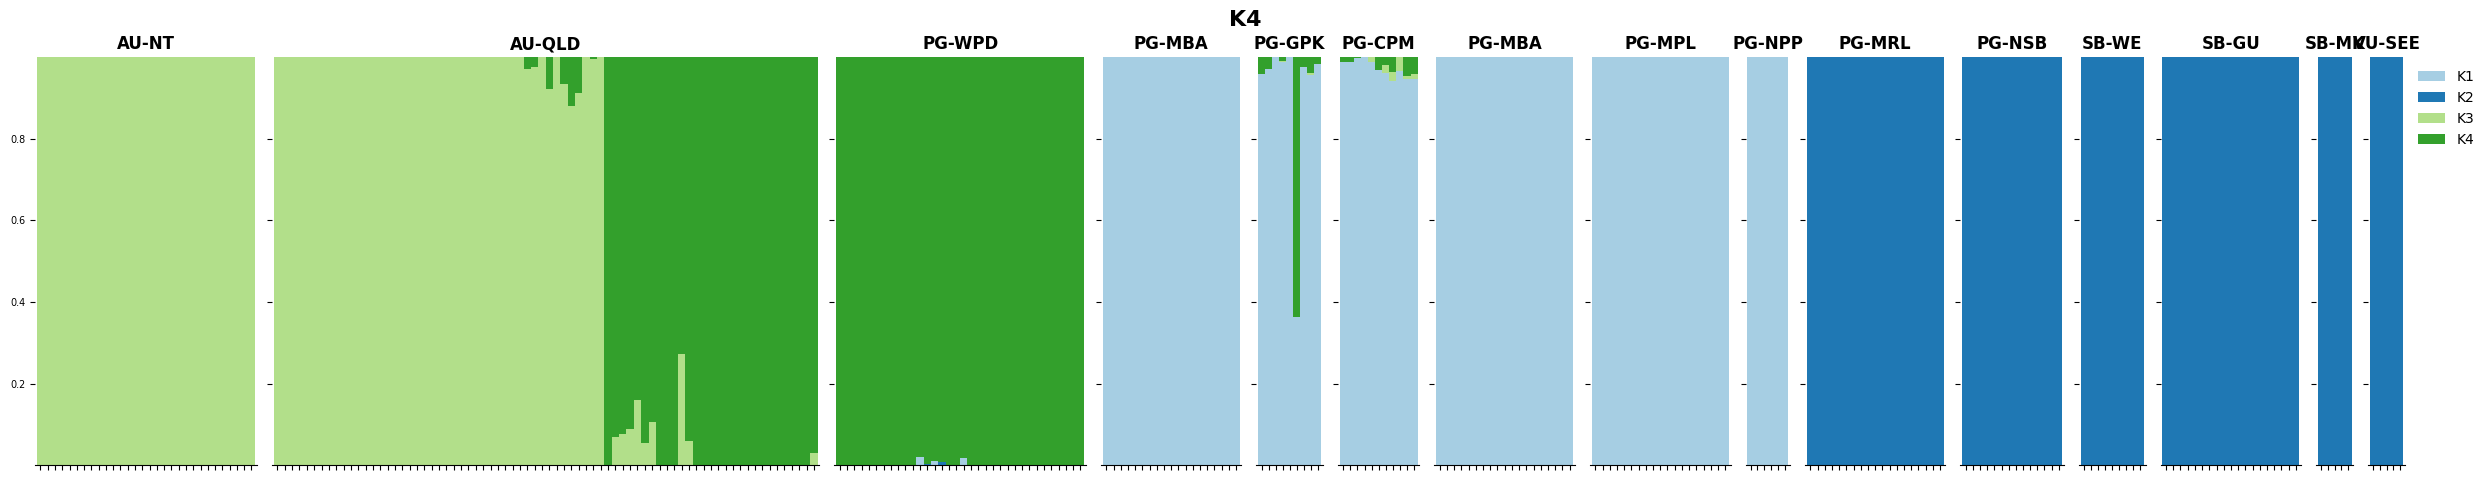

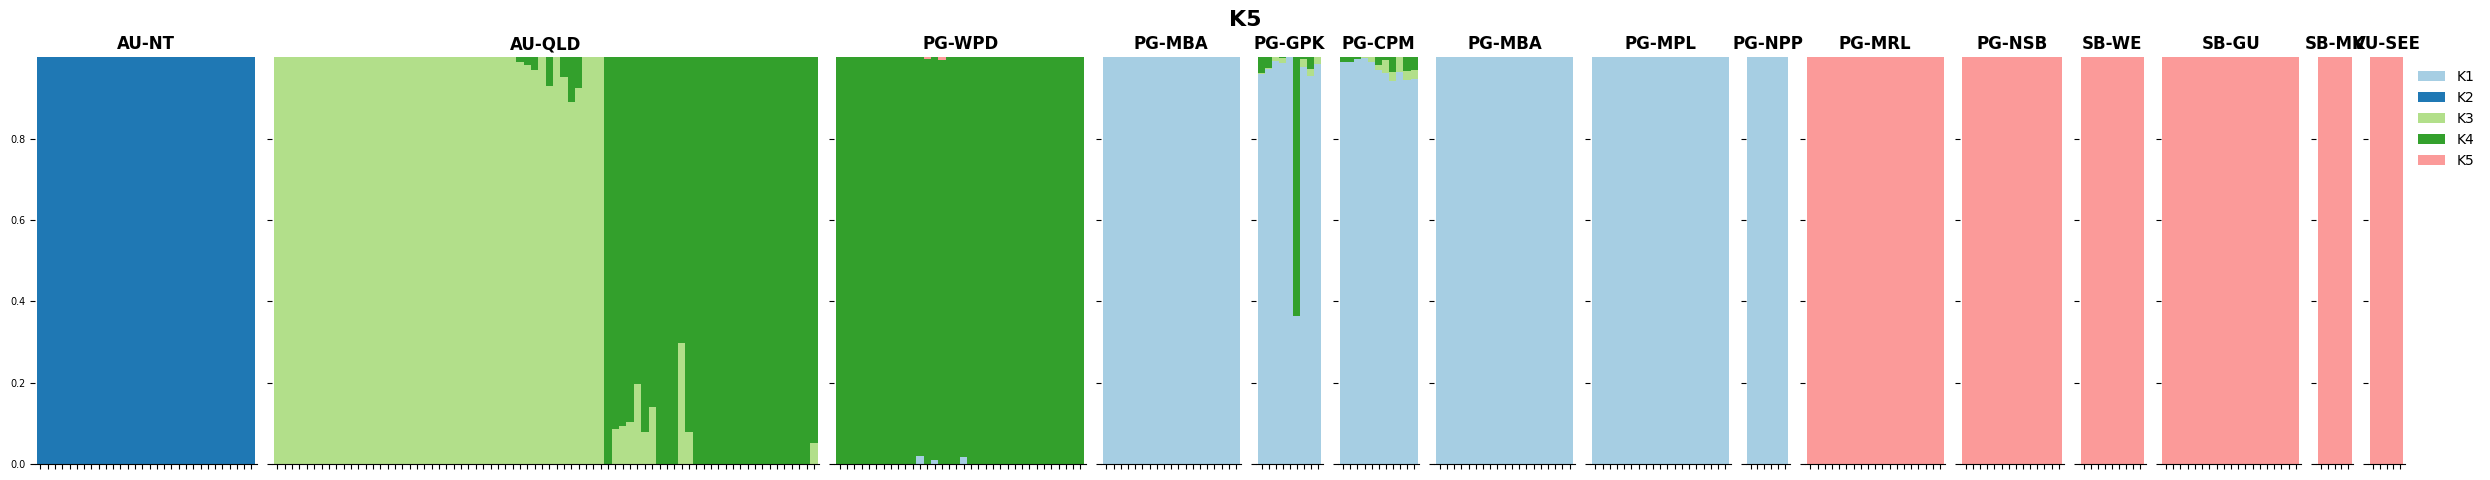

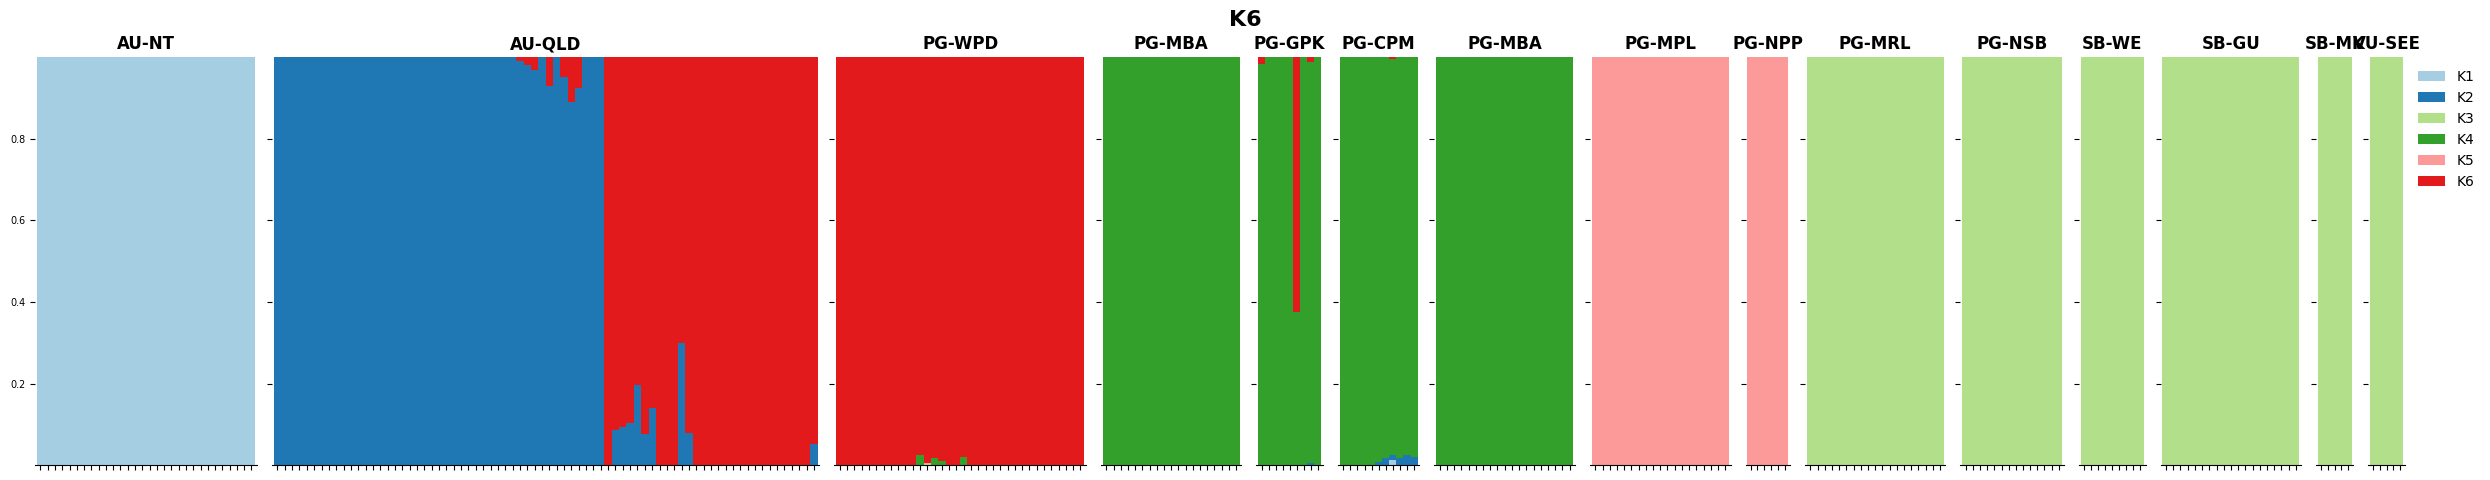

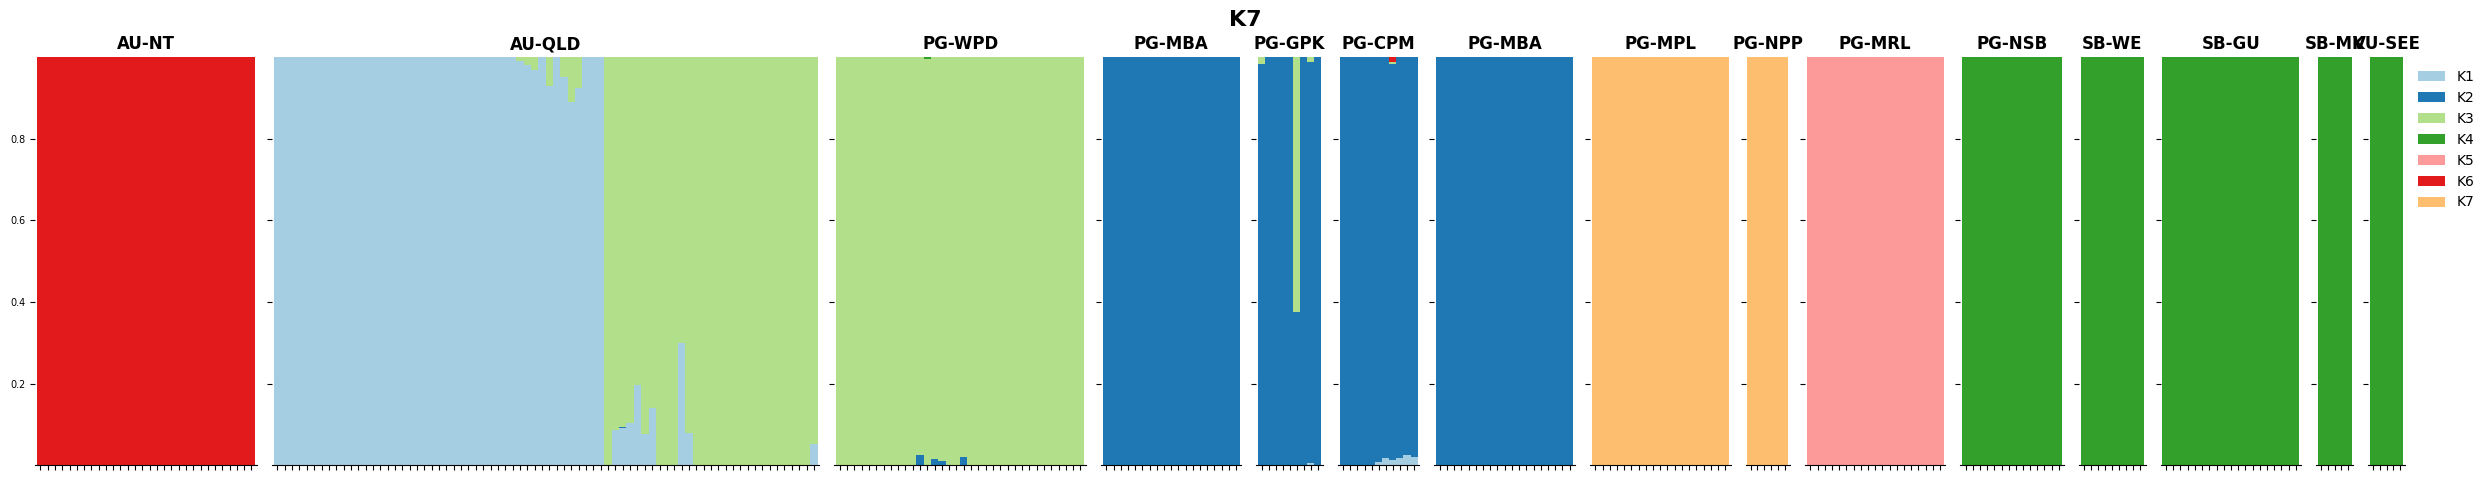

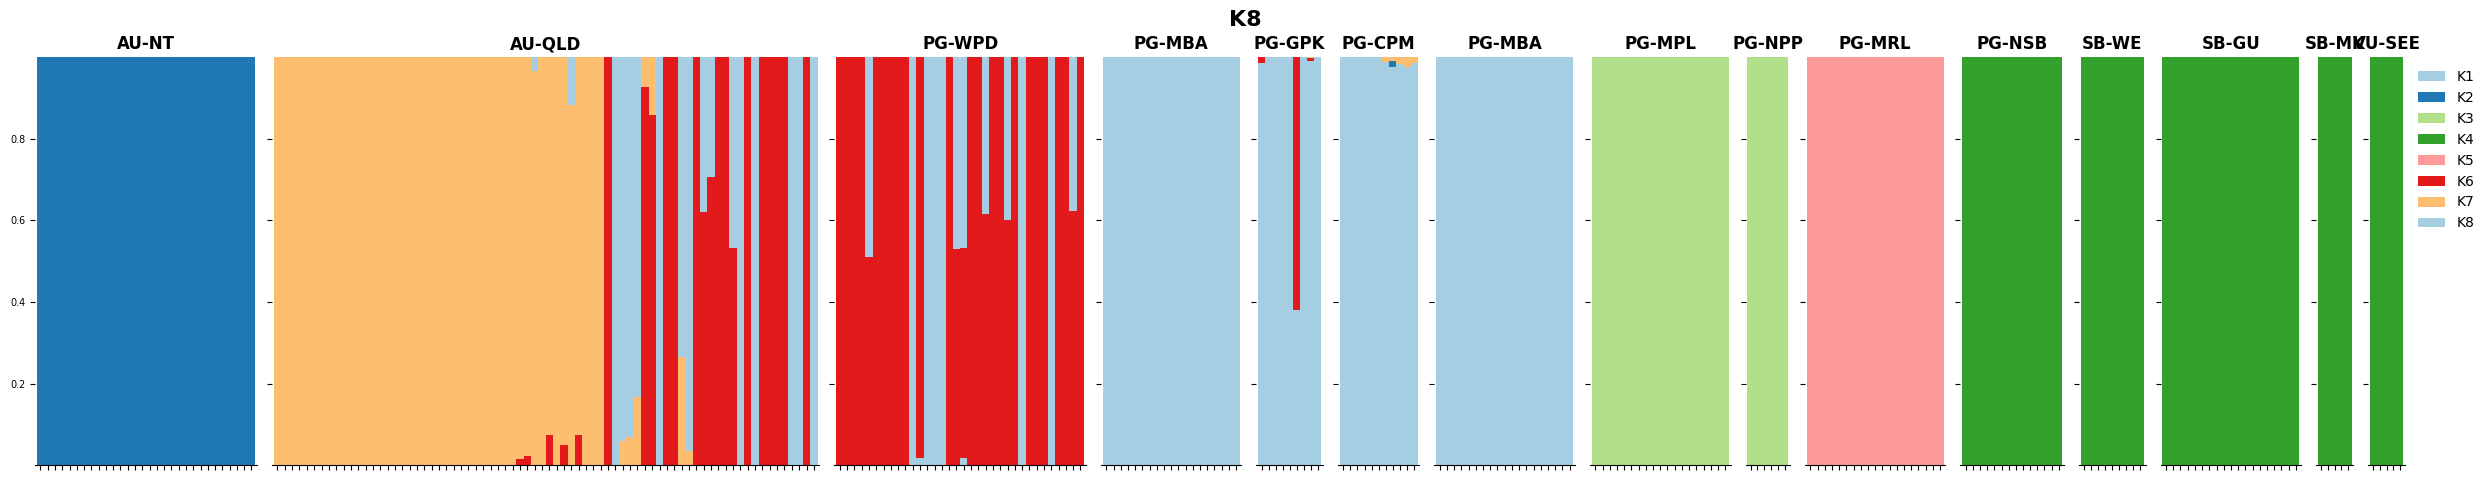

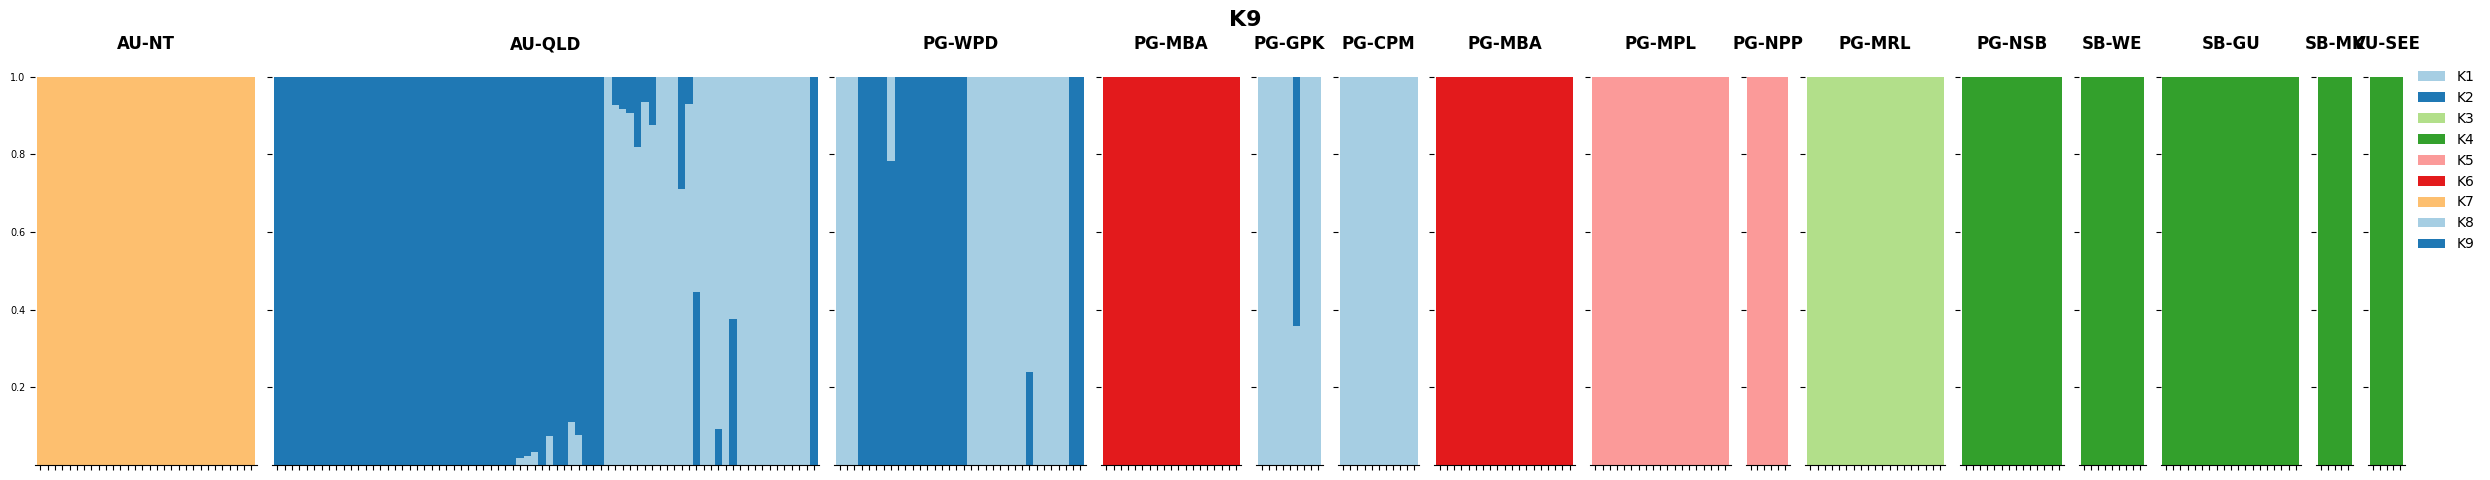

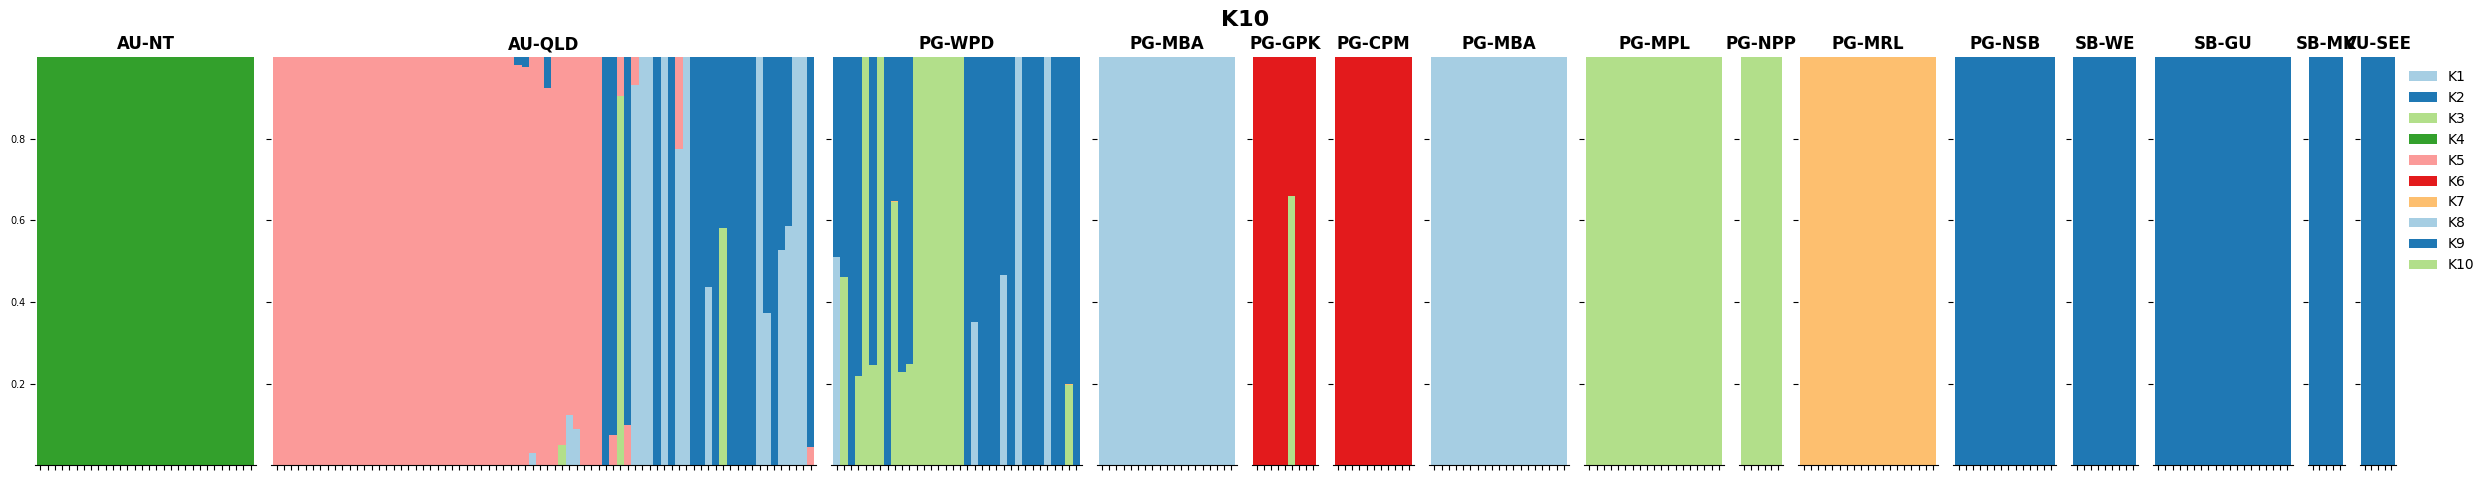

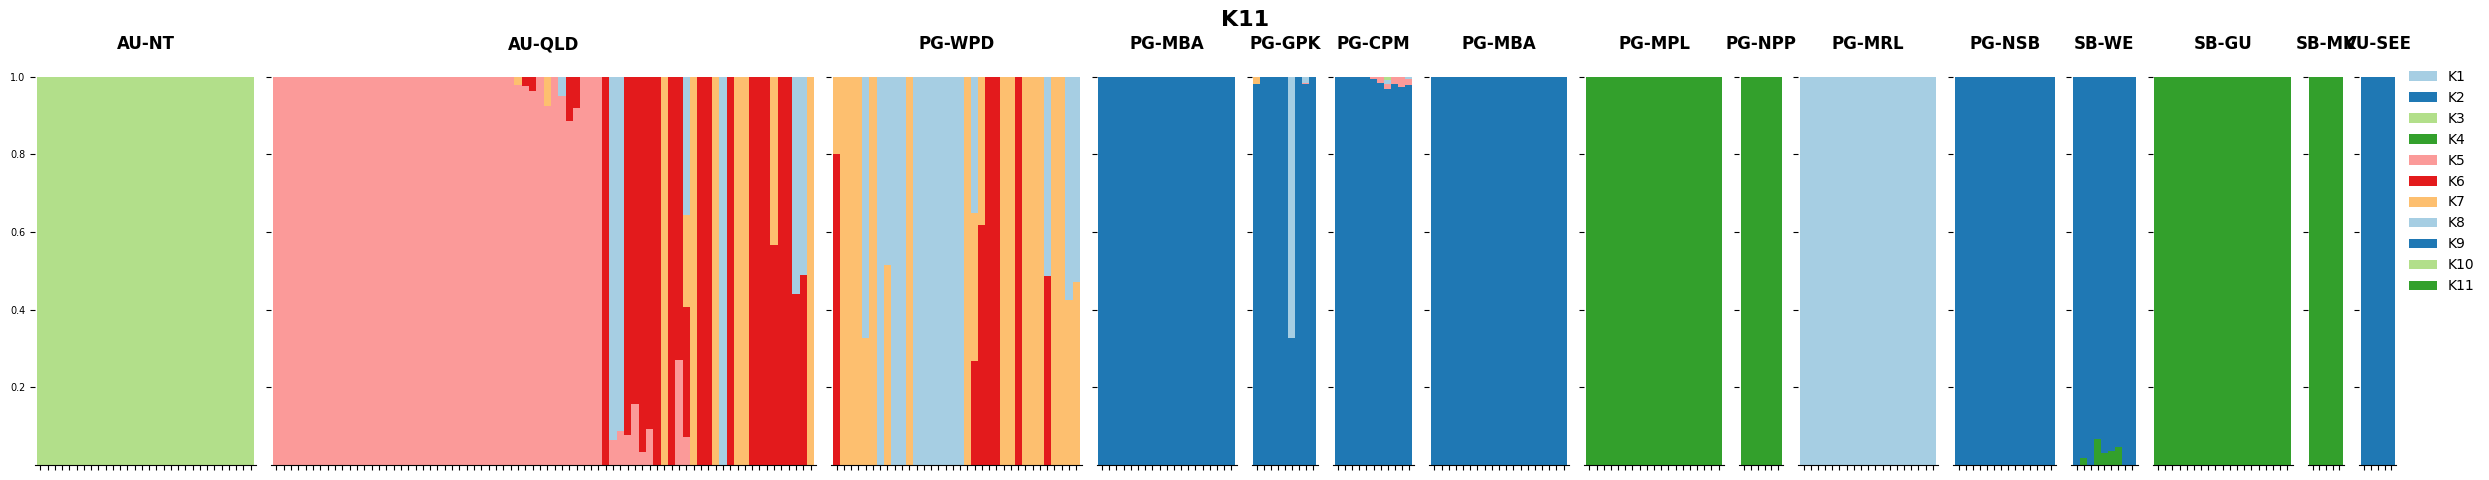

In [16]:
for i in range(1, 11+1):
    plot_barplot_byadmin1(i, outpath='figures')

In [36]:
# Noe let's try and plot these on a map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def draw_admix_pie(admix_fracs, x, y, colors, ax, 
                   radius=0.18, inset_width=0.5, inset_height=0.5, 
                   loc=10, linewidth=0.2, edgecolor="black"):
    """Draws a single admixture pie on a axis"""
    xy = (x, y)
    ax_i = inset_axes(ax, 
                      width=inset_width, 
                      height=inset_height, 
                      loc=loc, 
                      bbox_to_anchor=(x, y),
                      bbox_transform=ax.transData, 
                      borderpad=0)
    wedges, t = ax_i.pie(admix_fracs, 
                         colors=colors, 
                         center=(0, 0),  # center within the inset axes
                         radius=radius, 
                         wedgeprops={"linewidth": linewidth, 
                                     "edgecolor": edgecolor})
    ax_i.set_xlim(-1, 1)
    ax_i.set_ylim(-1, 1)
    return ax_i

def plot_admixture_scatterpie_map(q_df, location_df, title, pal, extent=[125, 171, -25, 0]):
    """
    Create scatterpie plot showing admixture proportions on a map
    """
    
    # Combine admixture data with location data
    combined_df = pd.concat([q_df.reset_index(), location_df.reset_index()], axis=1)
    
    # Get ancestry columns (adjust based on your data structure)
    ancestry_cols = [col for col in q_df.columns if isinstance(col, (int, str)) and 'K' in str(col)]
    if not ancestry_cols:  # fallback if no 'K' columns
        ancestry_cols = q_df.columns[:7].tolist()  # or however many K you have
    
    # Group by location and calculate mean ancestry proportions
    grouped = combined_df.groupby(['latitude', 'longitude']).agg({
        **{col: 'mean' for col in ancestry_cols},
        'country': 'first'
    }).reset_index()
    
    # Create map
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN, color='lightblue')
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Draw pie charts at each location
    for idx, row in grouped.iterrows():
        # Get ancestry proportions for this location
        proportions = [row[col] for col in ancestry_cols]
        
        # Skip if all proportions are zero or NaN
        if not any(p > 0 for p in proportions if not pd.isna(p)):
            continue
            
        # Draw pie chart at this location
        draw_admix_pie(
            admix_fracs=proportions,
            x=row['longitude'], 
            y=row['latitude'],
            colors=pal[:len(proportions)],
            ax=ax,
            radius=0.3,  # adjust pie size
            inset_width=0.8,  # adjust pie size
            inset_height=0.8,
            linewidth=0.5,
            edgecolor="black"
        )
    
    # Add title
    plt.title(f'ADMIXTURE Geographic Distribution: {title}', fontsize=14, fontweight='bold')
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                 markerfacecolor=pal[i], markersize=10, 
                                 label=f'K{i+1}') for i in range(len(ancestry_cols))]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, fancybox=True)
    
    plt.tight_layout()
    plt.savefig('figures/scatterpie.svg')
    plt.show()

# Usage


In [32]:
color_mapping = {
    'K1': '#A6CEE3',
    'K2': '#1F78B4', 
    'K3': '#B2DF8A',
    'K4': '#33A02C',
    'K5': '#FB9A99',
    'K6': '#E31A1C',
    'K7': '#FDBF6F'
}

/scratch/temp/16174269/ipykernel_1198075/2840569763.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


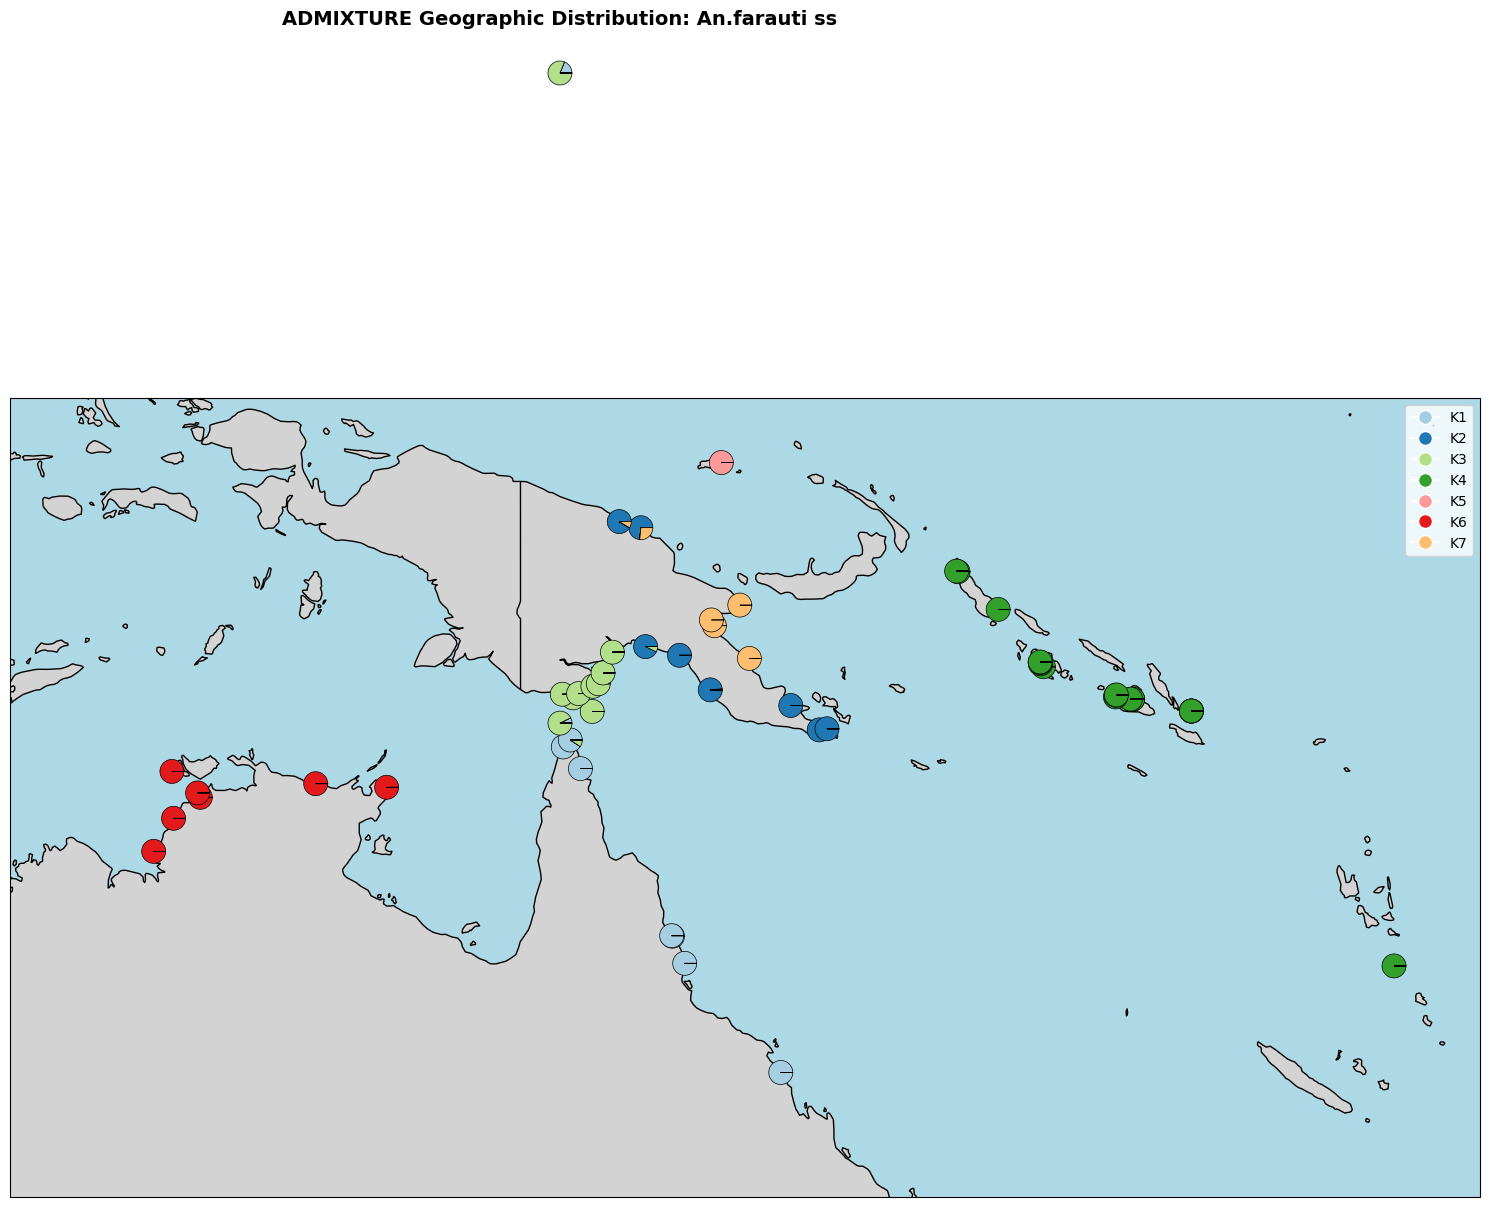

In [37]:
K=7
q = pd.read_csv(q_list[6][0], sep=' ', header=None)
pal = sns.color_palette("Paired", K)
plot_admixture_scatterpie_map(q, df_samples_analysis, "An.farauti ss", pal)